<a href="https://colab.research.google.com/github/borgesjose/reconhecimento_de_padroes/blob/master/WEEK%206/rfe_atv_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install scikit-optimize

     |████████████████████████████████| 100 kB 4.2 MB/s 


In [ ]:
pip install xgboost

# Seleção de Features c/ método wrapping: Recursive Feature Elimination

Atividade (1.25): realizar a seleção de features com o RFECV atendendo aos seguintes itens:
<ol>
        <li> Modifique a função select_features para receber como parâmetro de entrada o nome do seletor (RFE, KBest e Feature Importance). Para o feature importance, use a função do sklearn SelectFromModel e defina o modelo e o número máximo de features de modo a resultar em uma acurácia média superior a 74%; </li> 
        <li> Plotar um boxplot da acurácia obtida pelos classificador para cada seletor de features. Atenção: utilizar a versão da função get_best_model() que vocês desenvolveram na atividade anterior, contemplando os classificadores svm e gxboost;</li>    
</ol

In [ ]:
from pandas import read_csv
from numpy import nan
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectKBest, chi2

from sklearn.feature_selection import SelectFromModel

from sklearn.svm import SVC 

import xgboost as xgb


In [ ]:
#Fonte: https://www.kaggle.com/uciml/pima-indians-diabetes-database
#data = read_csv('pima-indians-diabetes.csv' , header=None)
data = read_csv('https://raw.githubusercontent.com/borgesjose/reconhecimento_de_padroes/master/WEEK%206/pima-indians-diabetes.csv')

In [ ]:
## eliminando dados faltantes
data.iloc[:,:-1] = data.iloc[:,:-1].replace(0, nan)
data.dropna(inplace=True)

In [ ]:
## Divisão treino/teste
x = data.iloc[:,:-1]
y = data.iloc[:,-1]

## 1 - Modifique a função select_features.

Modifique a função select_features para receber como parâmetro de entrada o nome do seletor (RFE, KBest e Feature Importance). Para o feature importance, use a função do sklearn SelectFromModel e defina o modelo e o número máximo de features de modo a resultar em uma acurácia média superior a 74%;

In [ ]:
def select_features(select_name, x_train, y_train, x_test): 
    
    if select_name == 'rfe':
      rfe = RFECV(estimator=DecisionTreeClassifier())
      rfe.fit(x_train, y_train)

    elif select_name == 'kbest':
      rfe = SelectKBest(chi2, k=2)
      rfe.fit(x_train, y_train)

    elif select_name == 'feature_importance':
      rfe = SelectFromModel(estimator=DecisionTreeClassifier())
      rfe.fit(x_train, y_train)

    else: 
      print("Oops! That was no valid selector. Try again...")

    x_train_fs = rfe.transform(x_train)
    x_test_fs = rfe.transform(x_test)

    return x_train_fs, x_test_fs, rfe

## 2 - Plotar Boxplot.

Plotar um boxplot da acurácia obtida pelos classificador para cada seletor de features. Atenção: utilizar a versão da função get_best_model() que vocês desenvolveram na atividade anterior, contemplando os classificadores svm e gxboost;

In [ ]:
def get_best_model_2(model_name, opt_name, x, y):
    
    import warnings
    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3,random_state=109) # 70% training and 30% test

    
    if model_name == 'd_tree':
        params = {'max_depth': [None, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]}
        model = DecisionTreeClassifier()
    elif model_name == 'r_forest':
        params = {'n_estimators': [10, 50, 100, 200], 'max_depth': [None, 1, 3, 5, 7]}
        model = RandomForestClassifier()
    elif model_name == 'svm':
        params = {'C': [1, 10, 50, 100]} #, 'gamma': [0.001, 0.0001]}
        model = SVC()
    elif model_name == 'gxboost':
        params = {'max_depth': [2, 4, 6], 'n_estimators': [50, 100, 200]}
        model = xgb.XGBClassifier()
    else:
        print("Oops! That was no valid model. Try again...")
    
    if opt_name == 'grid':
        grid = GridSearchCV(model,           
                            params,          
                            error_score=0.)  
        grid.fit(X_train, y_train) 

    elif opt_name == 'bayes':

        warnings.filterwarnings("ignore")

        grid = BayesSearchCV(model, params)
        grid.fit(X_train,y_train)

    else:
        print("Oops! That was no valid optmization method. Try again...")

    return grid

In [ ]:
def evaluate_model(model, x_test, y_test):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    scores = cross_val_score(model, x_test, y_test, scoring= 'accuracy' , cv=cv, n_jobs=-1)
    return scores

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

In [ ]:
# Seleção das features
x_train_fs, x_test_fs, fs = select_features('rfe',x_train, y_train, x_test)

# Capturar os melhores parâmetros do modelo
grid = get_best_model_2("r_forest", 'grid', x_train_fs, y_train)

# Instanciar o modelo com os melhores parâmetros e treiná-lo
#model = DecisionTreeClassifier(**grid.best_params_)
model = RandomForestClassifier(**grid.best_params_)
model.fit(x_train_fs, y_train)

# Avaliando o modelo
scores = evaluate_model(model,x_test_fs,y_test)
print( '%s > %.3f (%.3f) ' % ("r_forest",  mean(scores), std(scores)))

r_forest > 0.677 (0.048) 


In [ ]:
scores

array([0.64285714, 0.71428571, 0.57142857, 0.69230769, 0.76923077,
       0.71428571, 0.71428571, 0.71428571, 0.61538462, 0.69230769,
       0.64285714, 0.64285714, 0.64285714, 0.69230769, 0.69230769])

Text(0.5, 0.98, 'Boxplots - RFECV')

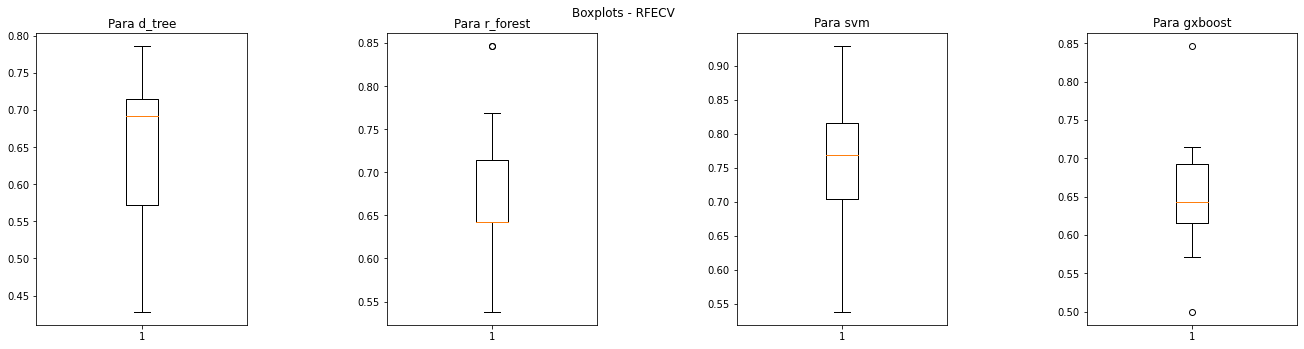

In [ ]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, 4)

tipos = ['d_tree','r_forest','svm', 'gxboost']

for k in range(0,4):
  x_train_fs, x_test_fs, fs = select_features('rfe',x_train, y_train, x_test)
  grid = get_best_model_2(tipos[k], 'grid', x_train_fs, y_train)

  if tipos[k] == 'd_tree':
    model = DecisionTreeClassifier(**grid.best_params_)
  if tipos[k] == 'r_forest':
    model = RandomForestClassifier(**grid.best_params_)
  if tipos[k] == 'svm':
    model = SVC(**grid.best_params_)
  if tipos[k] == 'gxboost': 
    model = xgb.XGBClassifier(**grid.best_params_)
  
  model.fit(x_train_fs, y_train)
  scores = evaluate_model(model,x_test_fs,y_test)
  
  axs[k].boxplot(scores)
  axs[k].set_title("Para "+ tipos[k])


fig.tight_layout()
fig.set_size_inches(20, 5)
fig.suptitle('Boxplots - RFECV')

Text(0.5, 0.98, 'Boxplots - KBEST')

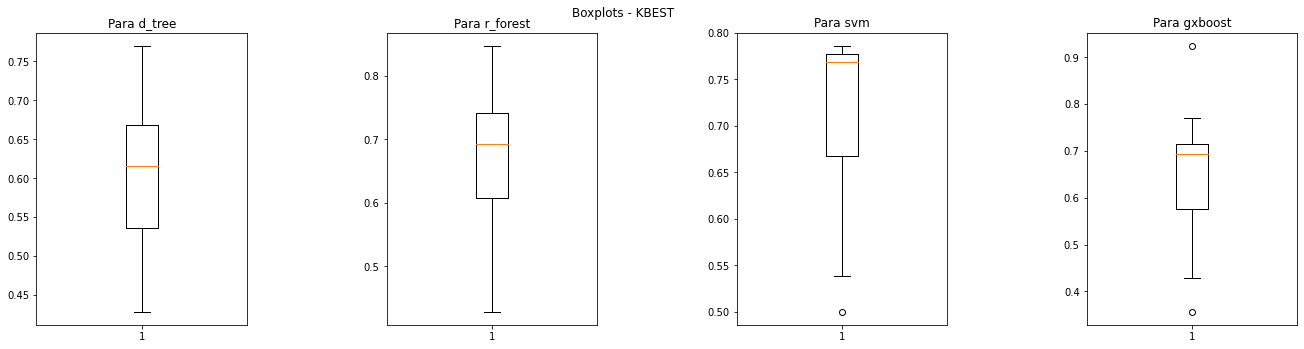

In [ ]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, 4)

tipos = ['d_tree','r_forest','svm', 'gxboost']

for k in range(0,4):
  x_train_fs, x_test_fs, fs = select_features('kbest',x_train, y_train, x_test)
  grid = get_best_model_2(tipos[k], 'grid', x_train_fs, y_train)

  if tipos[k] == 'd_tree':
    model = DecisionTreeClassifier(**grid.best_params_)
  if tipos[k] == 'r_forest':
    model = RandomForestClassifier(**grid.best_params_)
  if tipos[k] == 'svm':
    model = SVC(**grid.best_params_)
  if tipos[k] == 'gxboost': 
    model = xgb.XGBClassifier(**grid.best_params_)
  
  model.fit(x_train_fs, y_train)
  scores = evaluate_model(model,x_test_fs,y_test)
  
  axs[k].boxplot(scores)
  axs[k].set_title("Para "+ tipos[k])


fig.tight_layout()
fig.set_size_inches(20, 5)
fig.suptitle('Boxplots - KBEST')


Text(0.5, 0.98, 'Boxplots - RFECV')

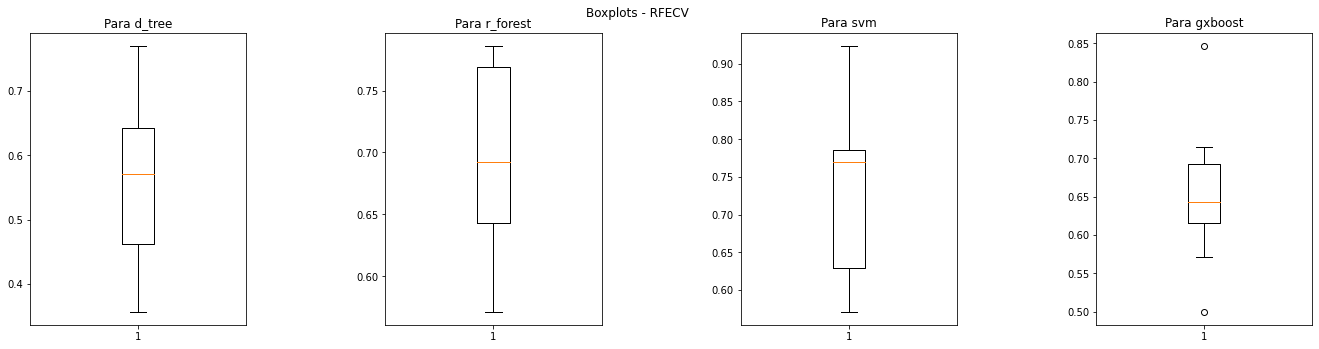

In [ ]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, 4)

tipos = ['d_tree','r_forest','svm', 'gxboost']

for k in range(0,4):
  x_train_fs, x_test_fs, fs = select_features('feature_importance',x_train, y_train, x_test)
  grid = get_best_model_2(tipos[k], 'grid', x_train_fs, y_train)

  if tipos[k] == 'd_tree':
    model = DecisionTreeClassifier(**grid.best_params_)
  if tipos[k] == 'r_forest':
    model = RandomForestClassifier(**grid.best_params_)
  if tipos[k] == 'svm':
    model = SVC(**grid.best_params_)
  if tipos[k] == 'gxboost': 
    model = xgb.XGBClassifier(**grid.best_params_)
  
  model.fit(x_train_fs, y_train)
  scores = evaluate_model(model,x_test_fs,y_test)
  
  axs[k].boxplot(scores)
  axs[k].set_title("Para "+ tipos[k])


fig.tight_layout()
fig.set_size_inches(20, 5)
fig.suptitle('Boxplots - RFECV')